In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import os
from glob import glob
import cv2
import os
import time

In [2]:
from models.CGNet.CGNetPyWandB import CGNet
model = CGNet()

In [3]:
model(torch.rand((1, 3, 1088, 1456)))

tensor([[[[ 0.0170, -0.0658,  0.0769,  ..., -0.0203, -0.1753, -0.0996],
          [-0.1584,  0.0333, -0.2022,  ..., -0.2046, -0.0213, -0.0384],
          [-0.1058, -0.1562, -0.2069,  ..., -0.0614, -0.0362,  0.0066],
          ...,
          [ 0.1530, -0.3539, -0.1708,  ..., -0.0434, -0.2244, -0.1440],
          [-0.2421, -0.2952, -0.1462,  ..., -0.1302, -0.1058, -0.1962],
          [-0.2952, -0.0168, -0.1471,  ..., -0.1445,  0.0148, -0.0739]]]],
       grad_fn=<MkldnnConvolutionBackward>)

In [4]:
image_dir = 'DanishTeam_Segmentation/Training/imgs/'
mask_dir = 'DanishTeam_Segmentation/Training/masks/'

In [5]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, image_dir, mask_dir, mask_suffix='', transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.mask_suffix = mask_suffix

    if transform == None:
      self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    else: 
      self.transform = transform
    self.ids = [os.path.splitext(file)[0] for file in os.listdir(image_dir)
                    if not file.startswith('.') and not '20210305' in file]

  def __getitem__(self, i):
    basename = self.ids[i]

    mask_file = glob(self.mask_dir + basename + self.mask_suffix + '.*')
    img_file = glob(self.image_dir + basename + '.*')

    mask = cv2.imread(mask_file[0])
    img = cv2.imread(img_file[0]) 
  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    img = self.transform(img)
    mask = self.transform(mask)
    base_array = torch.zeros_like(mask[0])
    base_array[mask[2] > 0.] = 1  
    base_array = base_array.reshape(1, base_array.shape[0], base_array.shape[1])

    return img, base_array

  def __len__(self):
    return len(self.ids)

In [6]:
dataset = CustomDataset(image_dir, mask_dir)
dataset[0][0].shape

torch.Size([3, 1088, 1456])

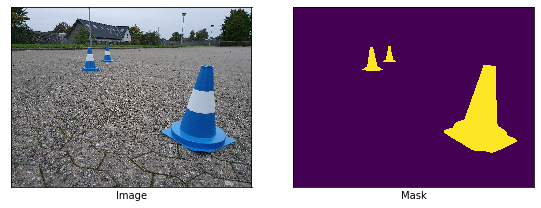

In [7]:
import matplotlib.pyplot as plt

def plot_class_masks(item: np.ndarray) -> None:
    """Plot a particular view of the true vs predicted segmentation.

    This function separates each class into its own image and
    does not perform any thresholding.

    Parameters:
        y_true: True segmentation (image_shape, num_classes).
        y_predicted: Predicted segmentation (image_shape, num_classes).
            If y_predicted is not provided, only the true values are displayed.
    """
    num_rows = 1

    num_columns = 2
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 4, num_rows * 4))
    axes = axes.reshape(-1, num_columns)
    plt.tight_layout()
    
    axes[0, 0].imshow(item[0].squeeze().permute(1,2,0))
    axes[0, 0].set_xlabel("Image")
    axes[0, 0].axes.set_xticks([])
    axes[0, 0].axes.set_yticks([])
    axes[0, 1].imshow(item[1].squeeze())
    axes[0, 1].set_xlabel("Mask")
    axes[0, 1].axes.set_xticks([])
    axes[0, 1].axes.set_yticks([])

    plt.show()

plot_class_masks(dataset[8])

In [8]:
dataset[0][0].dtype

torch.float32

In [9]:
def build_dataset(image_dir='DanishTeam_Segmentation/Training/imgs/', \
                      mask_dir='DanishTeam_Segmentation/Training/masks/'):
    
    dataset = CustomDataset(image_dir, mask_dir)
    
    tsplit = 0.15
    tsize = int(len(dataset)*tsplit)
    indices = torch.randperm(len(dataset)).tolist()

    train = torch.utils.data.Subset(dataset, indices[:-tsize])
    test = torch.utils.data.Subset(dataset, indices[-tsize:])

    train_loader = torch.utils.data.DataLoader(
      train,
      batch_size=1,
      shuffle=True,
      num_workers=0
    )

    test_loader = torch.utils.data.DataLoader(
        test,
        batch_size=1,
        shuffle=True,
        num_workers=0
    )
    
    return train_loader, test_loader

In [16]:
import wandb
wandb.login()
wandb.init(project="CGNet-Cones")

sweep_configuration = {
    'method': 'random',
    'name': 'stest_weep',
    'metric': {'goal': 'minimise', 'name': 'test_loss'},
    'parameters': 
    {
        'stage0_format': {'values': ['conv2', 'conv4', 'avmax']},
        'stage2_layers': {'values': [2, 3, 4, 6]},
        'stage3_layers': {'values': [8, 10, 12, 15, 20, 25]},
        'dropout': {'values': [0.05, 0.1, 0.15, 0.2]},
        'lr': {'max': 0.1, 'min': 0.0001}
     }
}

sweep_id = wandb.sweep(
  sweep=sweep_configuration, 
  project='ConeTestSweep'
  )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/floodd1@ad.mee.tcd.ie/.local/lib/python3.8/site-packages/wandb/__main__.py", line 1, in <module>
    from wandb.cli import cli
  File "/home/floodd1@ad.mee.tcd.ie/.local/lib/python3.8/site-packages/wandb/cli/cli.py", line 927, in <module>
    def launch_sweep(
  File "/usr/lib/python3/dist-packages/click/core.py", line 1234, in decorator
    cmd = command(*args, **kwargs)(f)

ServiceStartProcessError: The wandb service process exited with 1. Ensure that `sys.executable` is a valid python interpreter. You can override it with the `_executable` setting or with the `WANDB__EXECUTABLE` environment variable.

In [12]:
EPOCHS = 2
loss_func = nn.BCELoss()
print_every = 150
step = 0
checkpoint = True
train_loader, test_loader = build_dataset()

In [13]:
class CGNetEnd(nn.Module):
    def __init__(self):
        super(CGNetEnd, self).__init__()
        self.size = torch.Size([1088, 1456])
        
    def forward(self, x):
        out = F.interpolate(x, self.size, mode='bilinear', align_corners=True)
        out = torch.sigmoid(out)
        
        return out

In [14]:
for image, label in train_loader:
    print(image.shape)
    break

torch.Size([1, 3, 1088, 1456])


In [15]:
def train():
    model = CGNet(dropout_rate=wandb.config.dropout, stage0_format=wandb.config.stage0_format, \
                    M = wandb.config.stage2_layers, N = wandb.config.stage3_layers)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model_end = CGNetEnd()
    optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.lr)
    test_losses, train_losses = [], []

    for e in range(EPOCHS):
        running_loss = 0        
        for image, label in train_loader:
            image, label = image.to(device), label.to(device)
            step += 1
            optimizer.zero_grad()
            output = model(torch.tensor(image))
            output = model_end(output)
            loss = loss_func(output, torch.tensor(label))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if step % print_every == 0:
                test_loss = 0
                latency = []
                with torch.no_grad():
                    model.eval()
                    for image, label in test_loader:
                        before = time.time()
                        output = model(torch.tensor(image))#.double())
                        output = model_end(output)
                        latency.append(time.time() - before)
                        test_loss += loss_func(output, torch.tensor(label))
                    model.train()

                    for g in optimizer.param_groups:
                        g['lr'] *= 0.98

                    train_losses.append(running_loss/len(train_loader))
                    test_losses.append(test_loss/len(test_loader))

                    if not isinstance(checkpoint, bool): # checkpoint exists
                        if test_losses[-1] > test_losses[-2]*100:
                            model.load_state_dict(checkpoint)
                        else:
                            checkpoint = model.state_dict()
                    else:
                        checkpoint = model.state_dict()

                    print("Epoch: {}/{}.. ".format(e+1, EPOCHS),
                        "Latency: {:.5f}.. ".format(np.mean(np.array(latency))),
                        "Training Loss: {:.3f}.. ".format(running_loss / print_every),
                        "Test Loss: {:.3f}.. ".format(test_losses[-1])) 

                    wandb.log({
                        'latency': np.mean(np.array(latency)),
                        'train_loss': running_loss / print_every,
                        'test_loss': test_losses[-1]
                    })

                    running_loss = 0

    print("Done Training...")

wandb.agent(sweep_id, function=train, count=5)

/tmp/ipykernel_450261/2233430343.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(image))
/tmp/ipykernel_450261/2233430343.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_func(output, torch.tensor(label))
/tmp/ipykernel_450261/2233430343.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(image))#.double())
/tmp/ipykernel_450261/2233430343.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.

Epoch: 1/2..  Training Loss: 0.161..  Test Loss: 0.116.. 
Epoch: 1/2..  Training Loss: 0.054..  Test Loss: 0.068.. 
Epoch: 1/2..  Training Loss: 0.033..  Test Loss: 0.040.. 
Epoch: 1/2..  Training Loss: 0.039..  Test Loss: 0.057.. 
Epoch: 1/2..  Training Loss: 0.028..  Test Loss: 0.061.. 
Epoch: 1/2..  Training Loss: 0.024..  Test Loss: 0.052.. 
Epoch: 2/2..  Training Loss: 0.017..  Test Loss: 0.044.. 
Epoch: 2/2..  Training Loss: 0.022..  Test Loss: 0.039.. 
Epoch: 2/2..  Training Loss: 0.029..  Test Loss: 0.039.. 
Epoch: 2/2..  Training Loss: 0.022..  Test Loss: 0.036.. 
Epoch: 2/2..  Training Loss: 0.014..  Test Loss: 0.041.. 
Epoch: 2/2..  Training Loss: 0.016..  Test Loss: 0.036.. 
Done Training...


/tmp/ipykernel_450261/4198370425.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(image))


torch.Size([1, 1088, 1456]) torch.Size([1, 3, 1088, 1456])


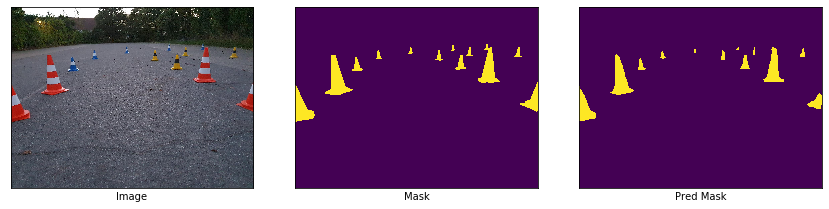

torch.Size([1, 1088, 1456]) torch.Size([1, 3, 1088, 1456])


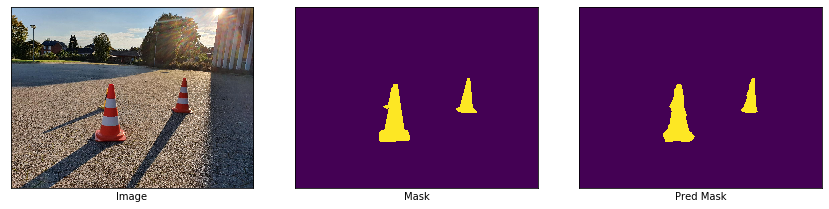

torch.Size([1, 1088, 1456]) torch.Size([1, 3, 1088, 1456])


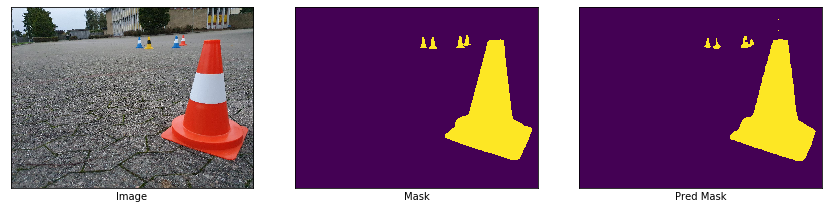

torch.Size([1, 1088, 1456]) torch.Size([1, 3, 1088, 1456])


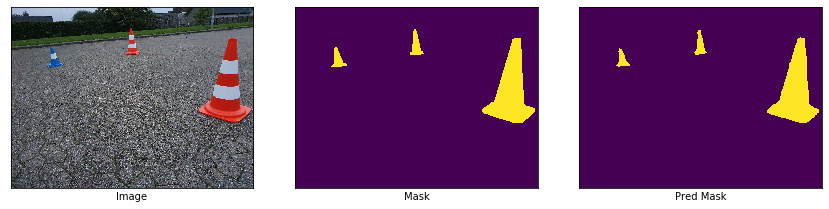

In [16]:
def display_pred_masks(model, image, label):
    num_rows = 1

    num_columns = 3
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 4, num_rows * 4))
    axes = axes.reshape(-1, num_columns)
    plt.tight_layout()
    
#     tensor_image = torch.tensor(image).double()
#     tensor_image = tensor_image.reshape(1, *tensor_image.shape)
#     output = model(tensor_image.double())
    
    output = model(torch.tensor(image))
    output = model_end(output)
        
    axes[0, 0].imshow(image.squeeze().permute(1,2,0))
    axes[0, 0].set_xlabel("Image")
    axes[0, 0].axes.set_xticks([])
    axes[0, 0].axes.set_yticks([])
    axes[0, 1].imshow(label.squeeze())
    axes[0, 1].set_xlabel("Mask")
    axes[0, 1].axes.set_xticks([])
    axes[0, 1].axes.set_yticks([])
    
    print(label.shape, image.shape)
    
    base_array = np.zeros_like(output.detach().numpy())
    base_array[output > 0.5] = 1
    
    axes[0, 2].imshow(base_array.squeeze())
    axes[0, 2].set_xlabel("Pred Mask")
    axes[0, 2].axes.set_xticks([])
    axes[0, 2].axes.set_yticks([])

    plt.show()

k = 0
for image, label in train_loader:
    display_pred_masks(model, image, label[0])
    if k == 3:
        break
    else:
        k += 1